<a href="https://colab.research.google.com/github/neskuchaevav/first-project/blob/main/chapters/chap19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget -N https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip
!unzip -uq dsplus_integrated_project_4.zip
!ls

--2025-03-08 16:46:50--  https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip
Resolving code.s3.yandex.net (code.s3.yandex.net)... 93.158.134.158, 2a02:6b8::2:158
Connecting to code.s3.yandex.net (code.s3.yandex.net)|93.158.134.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 150987455 (144M) [application/zip]
Saving to: ‘dsplus_integrated_project_4.zip’

dsplus_integrated_p 100%[===================>] 143.99M  20.3MB/s    in 8.3s    

2025-03-08 16:46:59 (17.4 MB/s) - ‘dsplus_integrated_project_4.zip’ saved [150987455/150987455]

dsplus_integrated_project_4.zip  __MACOSX  sample_data	to_upload


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import pickle
import nltk
import re
from nltk.corpus import stopwords
import os

from PIL import Image

#импортируем библиотеки для архитектуры нейронных сетей
from tensorflow.keras.layers import (Dense, GlobalAveragePooling2D, Flatten, Dropout, BatchNormalization)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow import keras
import tensorflow as tf
import keras_nlp

from tqdm import notebook

from sklearn.model_selection import GroupShuffleSplit, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

import sentence_transformers
from sentence_transformers import SentenceTransformer, util
from transformers import BertTokenizer
import torch
from torchvision import transforms
import glob

In [3]:
#загрузим необходимые модули для работы nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [4]:
import os
print(os.getcwd())

/content


In [5]:
direct = r'/content/to_upload'
RANDOM_STATE = 12345

np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

In [6]:
train_data = pd.read_csv(os.path.join(direct, 'train_dataset.csv'))
train_data.name = 'train_data'
data_crowd = pd.read_csv(os.path.join(direct, 'CrowdAnnotations.tsv'), sep='\t', names = ['image', 'query_id', 'fraction', 'pros', 'cons'])
data_crowd.name = 'data_crowd'
data_expert = pd.read_csv(os.path.join(direct, 'ExpertAnnotations.tsv'), sep='\t', names = ['image', 'query_id', 'first', 'second', 'third'])
data_expert.name = 'data_expert'
test_query = pd.read_csv(os.path.join(direct, 'test_queries.csv'), index_col=[0], sep='|')
test_query.name = 'test_query'
test_image = pd.read_csv(os.path.join(direct, 'test_images.csv'))
test_image.name = 'test_image'

In [7]:
for dataframe in [train_data, data_crowd, data_expert, test_query, test_image]:
    print('------------------------------------------------------------------------------------------------------------')
    print(dataframe.name)
    display(dataframe.head())
    print(dataframe.shape)
    print()

------------------------------------------------------------------------------------------------------------
train_data


,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


(5822, 3)

------------------------------------------------------------------------------------------------------------
data_crowd


,image,query_id,fraction,pros,cons
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0,3


(47830, 5)

------------------------------------------------------------------------------------------------------------
data_expert


,image,query_id,first,second,third
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2


(5822, 5)

------------------------------------------------------------------------------------------------------------
test_query


,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg


(500, 3)

------------------------------------------------------------------------------------------------------------
test_image


,image
0,3356748019_2251399314.jpg
1,2887171449_f54a2b9f39.jpg
2,3089107423_81a24eaf18.jpg
3,1429546659_44cb09cbe2.jpg
4,1177994172_10d143cb8d.jpg


(100, 1)



In [8]:
print('Количество уникальных фото на трейне:', len(train_data['image'].unique()))
print('Количество уникальных фото на тесте:', len(test_query['image'].unique()))

Количество уникальных фото на трейне: 1000
Количество уникальных фото на тесте: 100


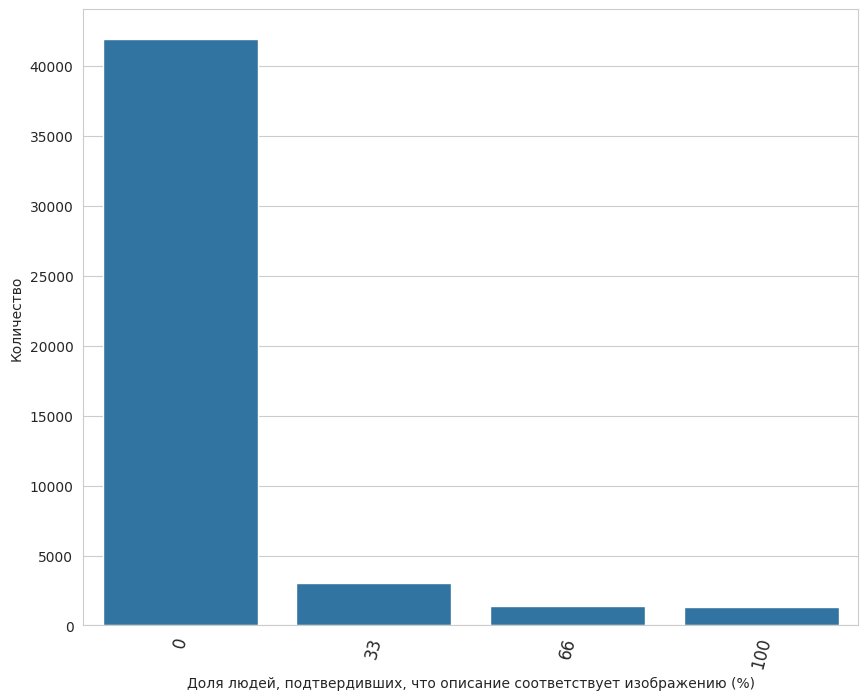

In [9]:
crowd_analicit = data_crowd.copy()
crowd_analicit['fraction'] *= 100
crowd_analicit['fraction'] = crowd_analicit['fraction'].astype('int')
crowd_array=[]
fraction_nums = np.array([0, 33, 66, 100])
for i in fraction_nums:
    crowd_array.append((crowd_analicit['fraction'] == i).sum())

sns.set_style("whitegrid")
plt.figure(figsize=(10, 8))
sns.barplot(x = fraction_nums, y = crowd_array)
plt.xticks(rotation=75, size=12)
plt.xlabel('Доля людей, подтвердивших, что описание соответствует изображению (%)')
plt.ylabel('Количество')
plt.show()

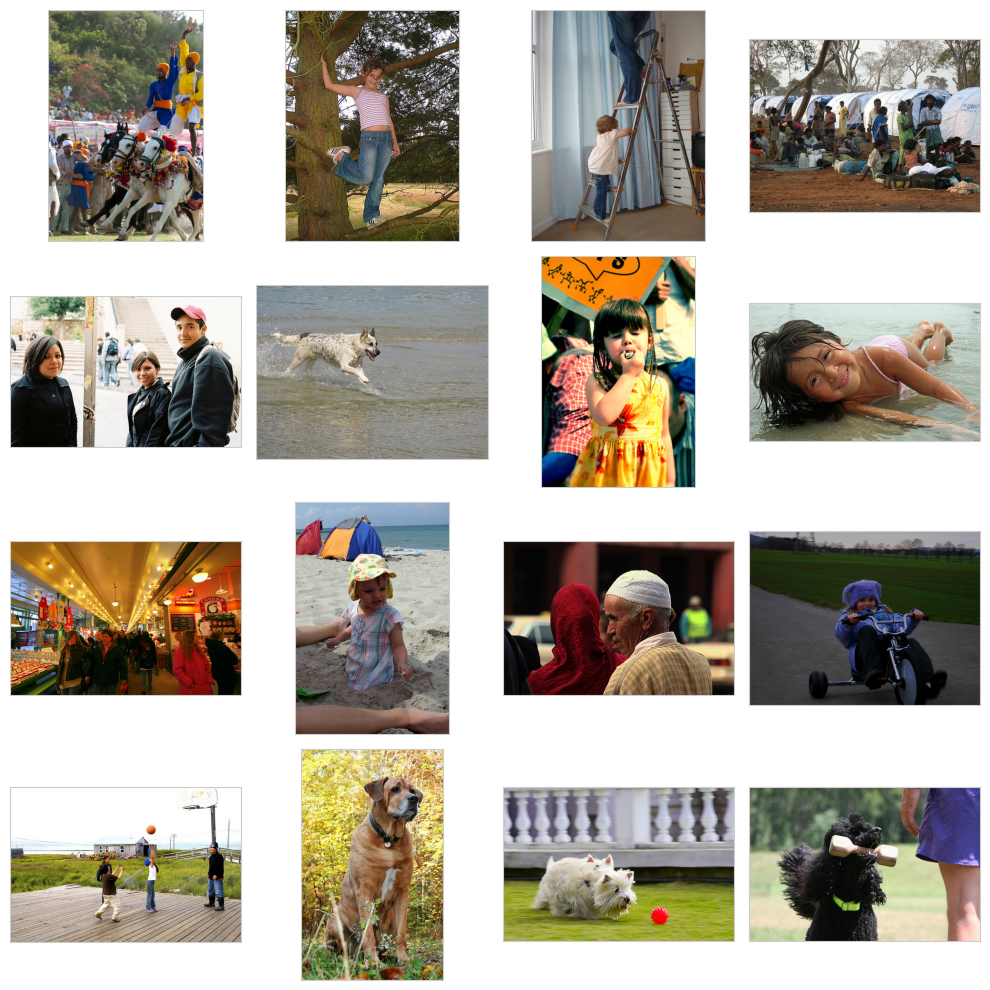

In [10]:
samples_train = list(train_data['image'].sample(8))
samples_test = list(test_query['image'].sample(8))

fig = plt.figure(figsize=(10,10))
for i in range(8):
    fig.add_subplot(4, 4, i+1)
    image = Image.open(Path(direct, 'train_images', samples_train[i]))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
for i in range(8):
    fig.add_subplot(4, 4, i+9)
    image = Image.open(Path(direct, 'test_images', samples_test[i]))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

## Агрегация
Нам нужно агрегировать оценки чтобы превратить их в целевую переменную. Сначала усредним и соберм оценки экспертов, потом объединим их с пользователями.

In [12]:
def expert_aggregate(row) -> object:

    '''поискав способы агрегации построим такой алгоритм, который будет агрегировать оценки'''

    if row['first'] != row['second'] != row['third']:
        row['expert_score'] = (row['first'] + row['second'] + row['third'] - 3) / 3 / 3

    else:
        row['expert_score'] = (max(set([row['first'], row['second'], row['third']]), key = [row['first'], row['second'], row['third']].count) - 1) / 3

    return row

data_expert = data_expert.apply(expert_aggregate, axis=1)

In [13]:
scores_data = pd.merge(data_expert, data_crowd, how='outer', on=['image', 'query_id'])

In [14]:
def score_aggregate(row) -> object:

    '''аггрегируем оценки людей и экспертов'''

    if np.isnan(row['expert_score']):
        row['score'] = row['fraction']
    elif np.isnan(row['fraction']):
        row['score'] = row['expert_score']
    else:
        row['score'] = row['expert_score'] * 0.7 + row['fraction'] * 0.3

    return row

scores_data = scores_data.apply(score_aggregate, axis=1)

In [15]:
display(scores_data.head())

,image,query_id,first,second,third,expert_score,fraction,pros,cons,score
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,NaN,NaN,NaN,NaN,1.0,3.0,0.0,1.0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,NaN,NaN,NaN,NaN,0.0,0.0,3.0,0.0
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,NaN,NaN,NaN,NaN,0.0,0.0,3.0,0.0
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,NaN,NaN,NaN,NaN,0.0,0.0,3.0,0.0
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,NaN,NaN,NaN,NaN,0.0,0.0,3.0,0.0


In [16]:
train_data = pd.merge(train_data, scores_data[['image', 'query_id', 'score']], how='outer', on=['image', 'query_id'])

Далее нам нужно заполнить пропуски. Поскольку данных уникальных не так много, то идентификаторы должны совпадать. ПОэтому нам надо сначала образовать датасет со всеми заполненными значениями.

Потом нужна функция, которая пройдется по идентификаторам и вставит текст туда, если идентификатор совпадает.

In [17]:
to_fill = train_data[train_data['query_text'].notna()]

In [18]:
def fill_text(row) -> object:

    if pd.isnull(row['query_text']):
        texts = to_fill[to_fill['query_id'] == row['query_id']]['query_text']
        if len(texts) > 0:
            row['query_text'] = texts.iloc[0]

    return row

train_data = train_data.apply(fill_text, axis=1)

In [19]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51323 entries, 0 to 51322
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       51323 non-null  object 
 1   query_id    51323 non-null  object 
 2   query_text  50214 non-null  object 
 3   score       51323 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.6+ MB


In [20]:
train_data.dropna(inplace=True)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50214 entries, 0 to 51322
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       50214 non-null  object 
 1   query_id    50214 non-null  object 
 2   query_text  50214 non-null  object 
 3   score       50214 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.9+ MB


### Выводы
Оценки аггрегированы, столбец для целевой переменной подготовлен.

## 2. Проверка данных
В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

- This image is unavailable in your country in compliance with local laws

Однако у нас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

In [21]:
disclaimer_words = ['teenage', 'baby', 'child', 'teenager', 'girl', 'boy', 'kid']

In [22]:
lemmatize = nltk.WordNetLemmatizer()

def get_lemmas(text):

    text = re.sub('[^a-zA-Z]', ' ', text).lower()
    text = nltk.word_tokenize(text, language = 'english')
    text = [lemmatize.lemmatize(word) for word in text]

    return text

def cleaning(row):

    text = get_lemmas(row['query_text'])
    if [i for i in text if i in disclaimer_words]:
        row['to_block'] = 1
    else:
        row['to_block'] = 0

    return row

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [27]:
train_data = train_data.apply(cleaning, axis=1)

In [28]:
print(train_data[train_data['to_block'] == 1]['query_text'].sample(10).unique())

['A kid hangs upside down on the monkey bars at a playground .'
 'A little girl sits in a plastic swing set .'
 'Two smiling little girls playing in a fountain with other people .'
 'A girl is wear a green dress .' 'girl posing on tree'
 'A young , long-haired , girl on the beach , is jumping in the air .'
 'A little girl twirls around in a flowery dress .'
 'Children play in a water spray .'
 'The two children swinging together on a swing .'
 'Kids playing in the water in front of a wooden bridge .']


In [29]:
train_data.drop(train_data[train_data['to_block'] == 1].index, inplace=True, errors='ignore')
train_data.drop(columns='to_block', inplace=True, errors='ignore')
train_data.reset_index(inplace=True, drop=True)

In [30]:
display(train_data.head(), test_query.head())

,image,query_id,query_text,score
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,"A woman is signaling is to traffic , as seen f...",1.0
1,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,"A woman wearing black clothes , a purple scarf...",0.0
2,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,An older woman with blond hair rides a bicycle...,0.0
3,1056338697_4f7d7ce270.jpg,2204550058_2707d92338.jpg#2,A woman wearing a white glove peers over the c...,0.0
4,1056338697_4f7d7ce270.jpg,2224450291_4c133fabe8.jpg#2,A man taking a picture with a silver camera .,0.0


,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg


### Выводы
Данные избавлены от запрещенного контента. Теперь приступаем к подготовки материала.

## 3. Векторизация изображений
Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

In [31]:
def load_train(path=direct):
    '''Применим аугментацию и создадим выборку'''

    norm = transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        norm,
    ])

    train_datagen = ImageDataGenerator(rescale=1/255.)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory=Path(path, 'train_images'),
        x_col='image',
        y_col='score',
        target_size=(256, 256),
        batch_size=16,
        class_mode='input',
        seed=RANDOM_STATE,
        shuffle=False,
        preprocessing_function=preprocess)

    return train_gen_flow

In [32]:
def create_model(input_shape=(256, 256, 3)):

    '''формируем архитектуру сети'''

    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    optimizer = Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mean_absolute_error'])

    return model

Получим эмбеддинги наших картинок.

In [33]:
def predicting(model, train_data):

    '''превращаем данные в вектор'''

    predictions = model.predict(train_data)

    return predictions

In [ ]:
%%time

pict_embeds = predicting(create_model(), load_train())

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Found 36125 validated image filenames.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 132/2258 ━━━━━━━━━━━━━━━━━━━━ 2:35:40 4s/step

In [ ]:
pict_embeds.shape

## 4. Векторизация текстов
Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- *трансформеры (например Bert)

* — если вы изучали трансформеры в спринте Машинное обучение для текстов.

In [ ]:
bert = keras_nlp.models.BertBackbone.from_preset('bert_base_en') #импортируем модель

In [ ]:
preprocessor = keras_nlp.models.BertPreprocessor.from_preset('bert_base_en') #напишем препроцессор для предобработки

In [ ]:
def vectorize_text(model, data, preprocessor=preprocessor, batch_size=32, bar=True, verbose=0):

    '''преобразуем тексты в словарь токенов, масок и паддингов'''

    embeddings = []
    tokenized = preprocessor(data)

    if bar:
        for i in notebook.tqdm(range(tokenized['token_ids'].shape[0] // batch_size + 1)):

            tokens = tokenized['token_ids'][batch_size*i:batch_size*(i+1)]
            token_types = tokenized['segment_ids'][batch_size*i:batch_size*(i+1)]
            mask = tokenized['padding_mask'][batch_size*i:batch_size*(i+1)]

            batch = {'token_ids' : tokens,
                    'segment_ids' : token_types,
                    'padding_mask' : mask}

            batch_embeddings = model.predict(batch, verbose=verbose)

            embeddings.append(batch_embeddings['pooled_output'])

    else:
        for i in range(tokenized['token_ids'].shape[0] // batch_size + 1):

            tokens = tokenized['token_ids'][batch_size*i:batch_size*(i+1)]
            token_types = tokenized['segment_ids'][batch_size*i:batch_size*(i+1)]
            mask = tokenized['padding_mask'][batch_size*i:batch_size*(i+1)]

            batch = {'token_ids' : tokens,
                    'segment_ids' : token_types,
                    'padding_mask' : mask}

            batch_embeddings = model.predict(batch, verbose=verbose)

            embeddings.append(batch_embeddings['pooled_output'])

    return np.concatenate(embeddings)

In [ ]:
text = list(train_data['query_text'])

In [ ]:
%%time

text_embeds = vectorize_text(model=bert, data=text)

In [ ]:
text_embeds.shape

## 5. Объединение векторов
Теперь осталось только собрать выборки.

In [ ]:
X = np.concatenate((pict_embeds, text_embeds), axis=1)
X.shape

In [ ]:
y = np.array(train_data['score'])
y.shape

In [ ]:
with open('X.pickle', 'wb') as f:
    pickle.dump(X, f)

with open('y.pickle', 'wb') as f:
    pickle.dump(y, f)

### Выводы
Признаки и цели готовы, можно обучать модели.

## 6. Обучение модели предсказания соответствия
Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки. Для того чтобы учесть изображения при разбиении, можно воспользоваться классом GroupShuffleSplit из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

    from sklearn.model_selection import GroupShuffleSplit
    gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
    train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
    train_df, test_df = df.loc[train_indices], df.loc[test_indices]

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

In [ ]:
gss = GroupShuffleSplit(n_splits=1, train_size=.8, random_state=RANDOM_STATE)
train_indices, test_indices = next(gss.split(X=X, y=y, groups=train_data['image']))

In [ ]:
X_train, X_test = X[train_indices], X[test_indices]

In [ ]:
y_train, y_test = y[train_indices], y[test_indices]

In [ ]:
scaler = StandardScaler().fit(X_train) #масштабируем данные
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Выбор модели
Поскольку задача носит регрессионный характер, то и модели будем использовать соответсвующие. Возьмем, к примеру метод опорных вектор, так как она довольно хорошо справляется как с классификацией, так и с регрессией, а также не требует большого количества времени.

Подходящей метрикой будет RMSE, потому что онf измеряется в тех же единицах, что и переменная ответа.

### LinearSVR
Попробуем модель метода опорных векторов.

Подберем гиперпараметры в GridSearch.

In [ ]:
'''model = LinearSVR(random_state=RANDOM_STATE)

param_grid = {
    'loss':['squared_epsilon_insensitive'],
    'C':[1]
}

gs_svr = GridSearchCV(
    model,
    param_grid,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    cv=GroupShuffleSplit(n_splits=3, random_state=RANDOM_STATE),
    verbose=1
)'''

In [ ]:
model = LinearSVR(random_state=RANDOM_STATE)
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

In [ ]:
print(f'Roor Mean Squared Error: {mse**0.5}')

Проведём подбор гиперпараметров.

In [ ]:
'''%time gs_svr.fit(X_train, y_train, groups=train_data['image'].loc[train_indices])
None'''

Посмотрим на результат.

Проверим полученную модель на тесте.

In [ ]:
'''pred = gs_svr.predict(X_test)
mean_absolute_error(y_test, pred).round(decimals=3)'''

### NeuralNetwork
Создадим трёхслоёную нейронную сеть.

In [ ]:
X_train.shape

In [ ]:
NN = Sequential()
NN.add(Dense(512, input_shape=(2816,), activation='relu'))
NN.add(Dropout(0.5))  # Добавляем Dropout с вероятностью 0.5
NN.add(BatchNormalization())
NN.add(Dense(256, activation='relu'))
NN.add(Dropout(0.5))  # Добавляем Dropout с вероятностью 0.5
NN.add(BatchNormalization())
NN.add(Dense(1, activation='relu'))

optimizer = Adam(learning_rate=1e-5)

NN.compile(optimizer=optimizer, loss='mean_squared_error',
            metrics=[tf.keras.metrics.RootMeanSquaredError()])

NN.build()

NN.summary()

In [ ]:
NN.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=32, epochs=10,
    verbose=2, shuffle=True
    )

### Выводы
Видно, что Нейронные сети лучше справляются с работой, выдавая относительно хороший результат. Так что для тестирования будем использовать их.

## 7. Тестирование модели
Настало время протестировать модель. Для этого получим эмбеддинги для всех тестовых изображений из папки test_images, выберем случайные 10 запросов из файла test_queries.csv и для каждого запроса выведем наиболее релевантное изображение. Сравним визуально качество поиска.

Создадим загрузчик тестовых изображений.

In [ ]:
def load_test(path=direct):

    '''Создадим данные для теста'''

    train_datagen = ImageDataGenerator(rescale=1/255.)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=test_image,
        directory=Path(path, 'test_images'),
        x_col='image',
        y_col=None,
        target_size=(256, 256),
        batch_size=16,
        class_mode='input',
        seed=RANDOM_STATE,
        shuffle = False)

    return train_gen_flow

Получим эмбеддинги тестовых картинок.

In [ ]:
%%time

pict_embeds_test = predicting(create_model(), load_test())
pict_embeds_test.shape

Напишем функцию, принимающую на вход текстовое описание и возвращающую 5 картиной с максимальной предсказанной оценкой схожести.

In [ ]:
def check_legality(text):
    if [i for i in get_lemmas(text) if i in disclaimer_words]:
        return False, 'This image is unavailable in your country in compliance with local laws.'
    return True, None

def get_similar_images(text):
    text_embed = vectorize_text(model=bert, data=[text], bar=False)
    X = np.concatenate((pict_embeds_test, np.resize(text_embed, (pict_embeds_test.shape[0],768))), axis=1)
    X = scaler.transform(X)
    predictions = NN.predict(X)
    df = pd.concat((test_image, pd.Series(np.reshape(predictions, (predictions.shape[0],)), name='pred')), axis=1)
    top = list(df.sort_values(by='pred', ascending=False)['image'].head(5))
    top_score = list(df.sort_values(by='pred', ascending=False)['pred'].head(5))
    return top, top_score

def display_images(top, top_score, text):
    fig = plt.figure(figsize=(15,5))
    plt.rcParams['axes.edgecolor'] = 'black'
    plt.rcParams['axes.linewidth'] = 0
    for i in range(5):
        fig.add_subplot(1, 6, i+1, title=round(top_score[i], 2))
        image = Image.open(Path(direct, 'test_images', top[i]))
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
    if text in list(test_query['query_text']):
        plt.rcParams['axes.edgecolor'] = 'green'
        plt.rcParams['axes.linewidth'] = 5
        fig.add_subplot(1, 6, 6)
        image = Image.open(Path(direct, 'test_images', test_query.iloc[test_query[test_query['query_text'] == text].index[0]]['image']))
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
    plt.show()

def get_picture(text):
    is_legal, message = check_legality(text)
    if not is_legal:
        print('-' * 20, text, '-' * 20)
        print('')
        print(message)
        print('')
        return None

    top, top_score = get_similar_images(text)

    print('')
    print('-' * 20, text, '-' * 20)
    print('')

    display_images(top, top_score, text)

    return None

Теперь выберем 10 случайных запросов из файла с тестовыми запросами и посмотрим на результаты.

In [ ]:
samples = test_query.sample(10)
text_test = list(samples['query_text'])
text_test

In [ ]:
for text in text_test:
    is_legal, message = check_legality(text)
    if not is_legal:
        print('-' * 20, text, '-' * 20)
        print('')
        print(message)
        print('')
        continue

    top, top_score = get_similar_images(text)

    print('')
    print('-' * 20, text, '-' * 20)
    print('')

    display_images(top, top_score, text)

In [ ]:
from torchvision.models import resnet50
from transformers import AutoTokenizer, AutoModel
from train_clip import CustomCLIPWrapper
import requests
from transformers import AutoProcessor, CLIPModel

In [ ]:
img_encoder = resnet50(pretrained=True)
img_encoder.fc = torch.nn.Linear(2048, 768)
tokenizer = AutoTokenizer.from_pretrained("johngiorgi/declutr-sci-base")
txt_encoder = AutoModel.from_pretrained("johngiorgi/declutr-sci-base")
model = CustomCLIPWrapper(img_encoder, txt_encoder, minibatch_size, avg_word_embs=True)

In [ ]:
python train.py --model_name RN50 --folder data_dir --batchsize 512

In [ ]:
model = CLIPModel.from_pretrained('/content')
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
inputs = processor(
    text=["a photo of a cat", "a photo of a dog"], images=image, return_tensors="pt", padding=True
)
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)

## Заключение
В рамках этого проекта мы создали минимально работоспособную версию системы поиска изображений, основанную на фотографии. Для векторизации изображений мы использовали сеть ResNet50, а для текстовых эмбеддингов - BERT base cased EN.

Мы испытали модели для оценки схожести:

- LinearSVR
- Трёхслойная нейронная сеть

Однако, наилучшие результаты были получены с помощью трёхслойной нейронной сети.

В конце работы мы разработали функцию, которая на основе текстового запроса возвращает 5 наиболее похожих картинок. Эта функция была протестирована на наборе тестовых картинок.

Возможные пути для улучшения модели включают использование полного набора картинок из датасета Flickr30k и смену архитектуры решения.